In [3]:
import numpy as np
import os
import cv2
import h5py
import math
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
import prepare_data as pd

In [9]:
# define model type
SRCNN = Sequential()
    
 # add model layers
SRCNN.add(Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
SRCNN.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))

# SRCNN.summary()
SRCNN.compile(optimizer='adam', loss='mse', metrics=['mse'])

Evaluate

In [10]:
# define function for peak signal-to-noise ration (PSNR)
def psnr(target, ref) : 
    
    # assume RGB/BGR image
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))
    
    return 20 * math.log10(255./ rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    
    # MSE is the sum of the squared fifference between the two the images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel= True))
    
    return scores

Predict

In [11]:
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img

def shave(image, border):
    img = image[border:-border, border:-border]
    return img

In [12]:
x = cv2.imread('downgraded_img.jpg')
y = cv2.imread('baby.jpg')

print(x.shape, y.shape)

(716, 728, 3) (716, 728, 3)


In [36]:
def predict(image_path):
    
    SRCNN.load_weights('SRCNN weights.h5')
    
    # load the degraded and reference images
    ref = cv2.imread('Set5/butterfly_GT.bmp')
    degraded = cv2.imread(image_path)

    # preprocess the image with madcrop
    ref = modcrop(ref, 2)
    degraded = modcrop(degraded, 2)
    
    # convert the image to VCrCb - (srccn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = SRCNN.predict(Y, batch_size=128)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR) 
    
    # remove border from reference and degraded image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality caluclations (평가지표 로드)
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

Degraded Image : 
PSNR: 24.749060820274682
MSE: 653.5751534777036
SSIM: 0.8788805942508308

Reconstructed Image : 
PSNR: 29.889875166843545
MSE: 200.08480064764217
SSIM: 0.9486816719179642



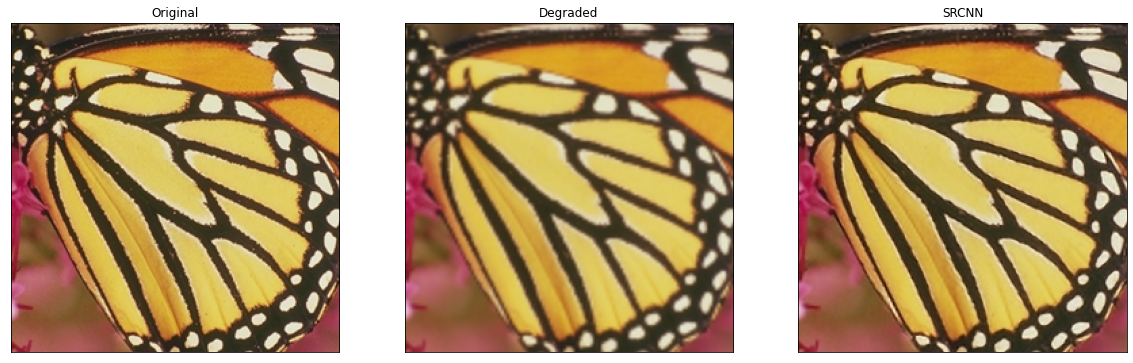

In [37]:
ref, degraded, output, scores = predict('deSet5/butterfly_GT.bmp')

# print all scores for all images
print('Degraded Image : \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image : \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20,8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original")
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title("Degraded")
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title("SRCNN")

# remove the x and y tick marks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [53]:
x = cv2.imread('Remini.jpg')
x = cv2.resize(x, (243, 244), interpolation=cv2.INTER_LINEAR)
x = x.reshape(1, 244, 243, 3)
x.shape

(1, 244, 243, 3)

In [54]:
plt.imread(x)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [48]:
img = compare_images(x, ref)
print(img)

[12.239597617110334, 11647.744990892532, 0.3036695850237105]
